## Quantum Approximate Optimization Algorithm (QAOA)
method for solving combinatorial optimization problems on NISQ devices

@wiki Vertex Cover https://en.wikipedia.org/wiki/Vertex_cover ( node cover )
@additional for jupyter https://towardsdatascience.com/12-jupyter-notebook-extensions-that-will-make-your-life-easier-e0aae0bd181


If you have a newer graphic card --> try this https://developer.nvidia.com/cudnn
https://www.techentice.com/how-to-make-jupyter-notebook-to-run-on-gpu/


different optimizers
different devices
built-in cost 
built-in mixer Hamiltonians



In [46]:
#%load_ext jupyternotify
%matplotlib inline  

#import pyopencl as cl

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics(
    ip,
    option_name="option_value"
))

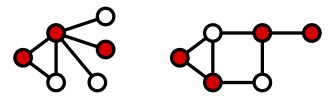


In [73]:

#from qiskit import IBMQ
#IBMQ.get_provider(hub='ibm-q', group='open', project='main')

import pennylane as qml
dev = qml.device('qiskit.ibmq',
                 wires=2,
                 backend='ibmq_belem',
                 ibmqx_token="yourKEY")

#dev.capabilities()['backend']


H = qml.Hamiltonian(
    [1, 1, 0.5],
    [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
)
print(H)

DeviceError: Device does not exist. Make sure the required plugin is installed.

In [5]:
dev = qml.device('default.qubit', wires=2)

t = 1
n = 2

@qml.qnode(dev)

def circuit():
    qml.templates.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)())

 0: ──H──────RZ(1)──H──H──╭RZ(0.5)──H──H──────RZ(1)──H──H──╭RZ(0.5)──H──┤ ⟨Z⟩ 
 1: ──RZ(1)──H────────────╰RZ(0.5)──H──RZ(1)──H────────────╰RZ(0.5)──H──┤ ⟨Z⟩ 



Use a built circuit to repeat a process in a layer 

In [6]:
def circuitModel(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(param):
    circuitModel(param)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)(0.5))

 0: ──RX(0.5)──╭C──┤ ⟨Z⟩ 
 1: ──H────────╰X──┤ ⟨Z⟩ 



Now we add this funtion for the circuit in the layer


In [25]:
@qml.qnode(dev)
def circuit(params, **kwargs):
    qml.layer(circuitModel, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

print(qml.draw(circuit)([0.3, 0.4, 0.5]))

 0: ──RX(0.3)──╭C──RX(0.4)──╭C──RX(0.5)──╭C──┤ ⟨Z⟩ 
 1: ──H────────╰X──H────────╰X──H────────╰X──┤ ⟨Z⟩ 



As a useablke circuit in a layer we are ready to implemnt in an QAOA

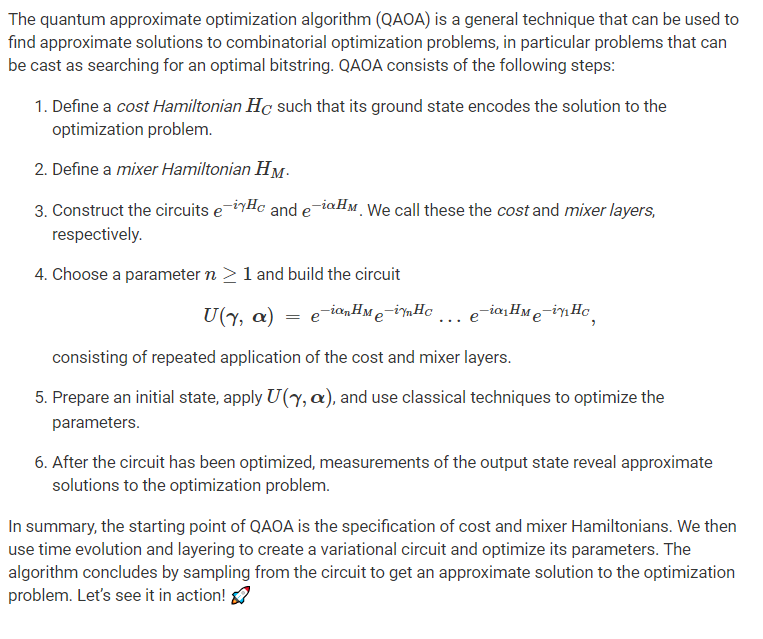


Finding the Minimum Vertex ( Node ) Cover with QAOA

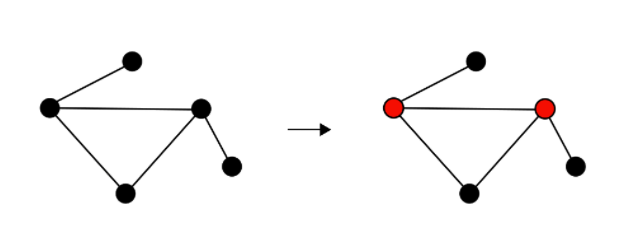

In [32]:
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

 

''' 
If you wish to see the drawing direct in Jupyter Notebook use ...
'''
#%matplotlib inline 

A Graph is represented by nodes and edges. A node has minimum of one edge and one edge connects two nodes. The Edges explains the distance or cost for a "way"
Deeper Informations to Graph-Theorie: https://de.wikipedia.org/wiki/Graphentheorie

There are two different kinds of graphs. "Zyklisch" and "azyklisch" ( cyclic and acyclic ) . The cyclic graphs  descibes ways, trees or similar. The acyclic graphs represent inner Cycles or circles.
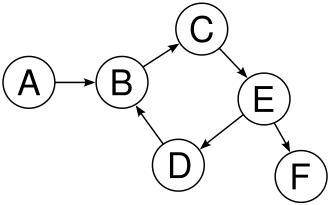

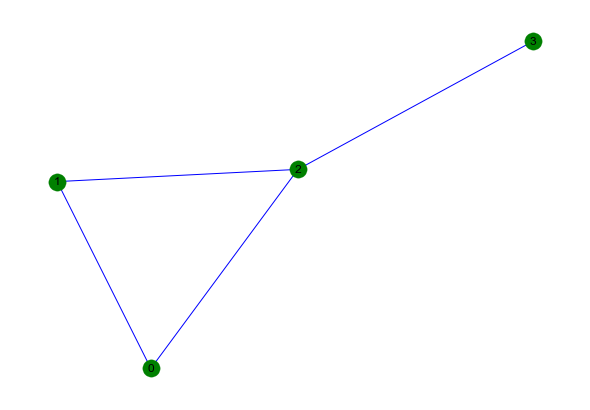

In [33]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True, node_color='green', edge_color='b')
plt.show()

There are two minimum vertex ( node ) covers of this graph: the vertices 0 and 2, and the vertices 1 and 2. These can be respectively represented by the bit strings 1010 and 0110. The goal of the algorithm is to sample these bit strings with high probability.

The PennyLane QAOA module has a collection of built-in optimization problems, including minimum vertex cover. For each problem, you can retrieve the cost Hamiltonian as well as a recommended mixer Hamiltonian. This makes it straightforward to obtain the Hamiltonians for specific problems while still permitting the flexibility to make other choices, for example by adding constraints or experimenting with different mixers.

In our case, the cost Hamiltonian has two ground states, 
|
1010
⟩
 and 
|
0110
⟩
, coinciding with the solutions of the problem. The mixer Hamiltonian is the simple, non-commuting sum of Pauli-X operations on each node of the graph:

In [34]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (-0.25) [Z3]
+ (0.5) [Z0]
+ (0.5) [Z1]
+ (1.25) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
Mixer Hamiltonian   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


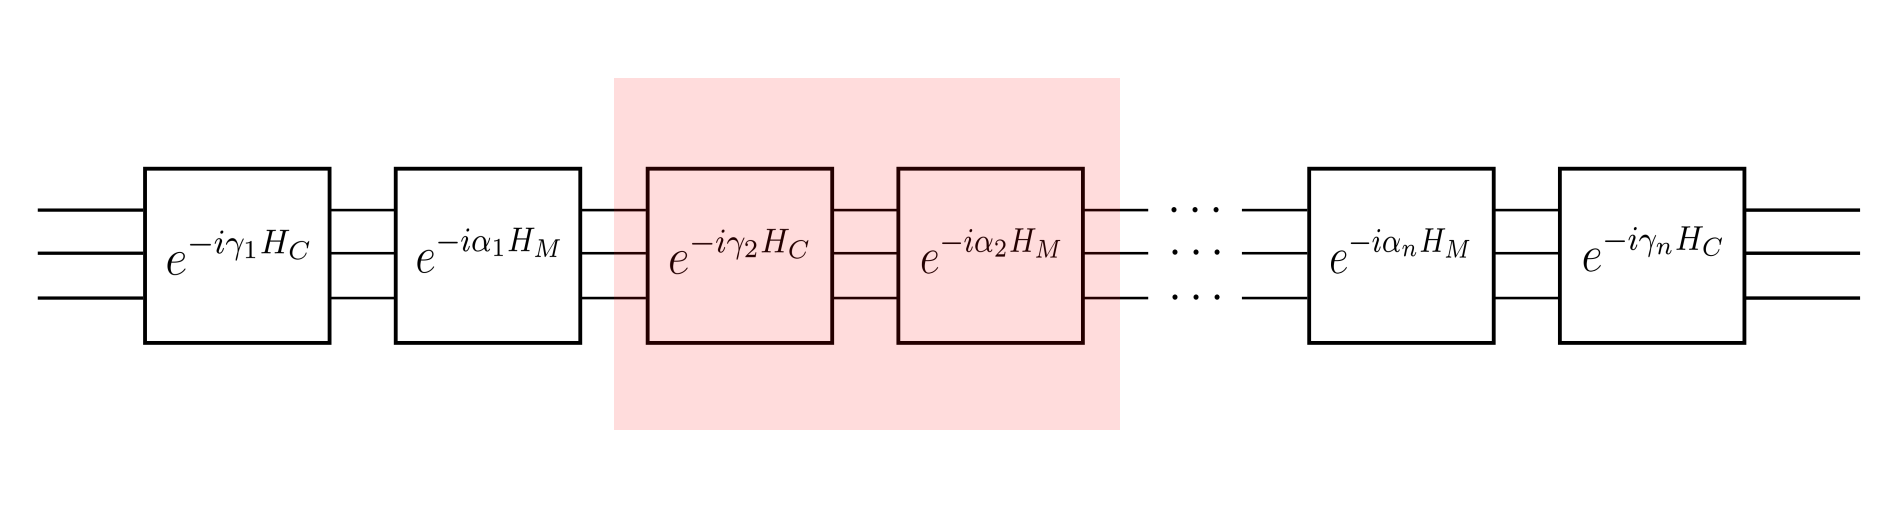


While it is possible to use ApproxTimeEvolution(), the QAOA module allows you to build the cost and mixer layers directly using the functions cost_layer() and mixer_layer(), which take as input the respective Hamiltonian and variational parameters:

In [35]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

We are now ready to build the full variational circuit. The number of wires is equal to the number of vertices of the graph. We initialize the state to an even superposition over all basis states. For this example, we employ a circuit consisting of two QAOA layers:

In [36]:
wires = range(4)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

Qulacs is a Variational Quantum Circuit Simulator for Quantum Computation Research

@git https://github.com/PennyLaneAI/pennylane-qulacs
@git https://github.com/qulacs

In [37]:
dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

Here we have the chance to mke a small digression in the field of optimization and Optimizers:
https://app.gitbook.com/s/-MjY9ZUOIiOq3c33tSsV/c/8gCGeGpncUNT6Yjaegcj/qml-projects/optimizer

In [47]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
init_parameter = 0.8

params = np.array([[init_parameter, init_parameter], [init_parameter, init_parameter]], requires_grad=True)

the initial parameters to 0.5 (For demonstration purposes) we chose as initial parameters that we know work fairly well, and don’t get stuck in any local minima. Means that the initial parameter is and important choise and can get a big problem to find good one 

## Optimization of the parameter 0.5 
This step can take some time .... 

In [62]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params, " 0.8 ")

Optimal Parameters
[[0.4435448  0.97550738]
 [0.27554951 0.7905865 ]]  0.8 


If you work dont forget to store you progress externaly or in a box 

Optimal Parameters 0.6

[[0.59805809 0.94198991]

 [0.52797339 0.85553284]]

Optimal Parameters 0.5

[[0.59806352 0.94198485]

 [0.52797281 0.85552845]]

With the optimal parameters, we can now reconstruct the probability landscape. We redefine the full QAOA circuit with the optimal parameters, but this time we return the probabilities of measuring each bitstring:

In [63]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])


## Getting the result

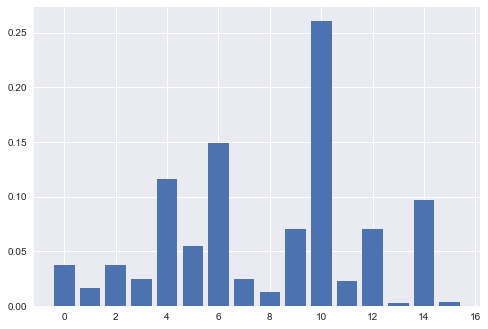

In [64]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

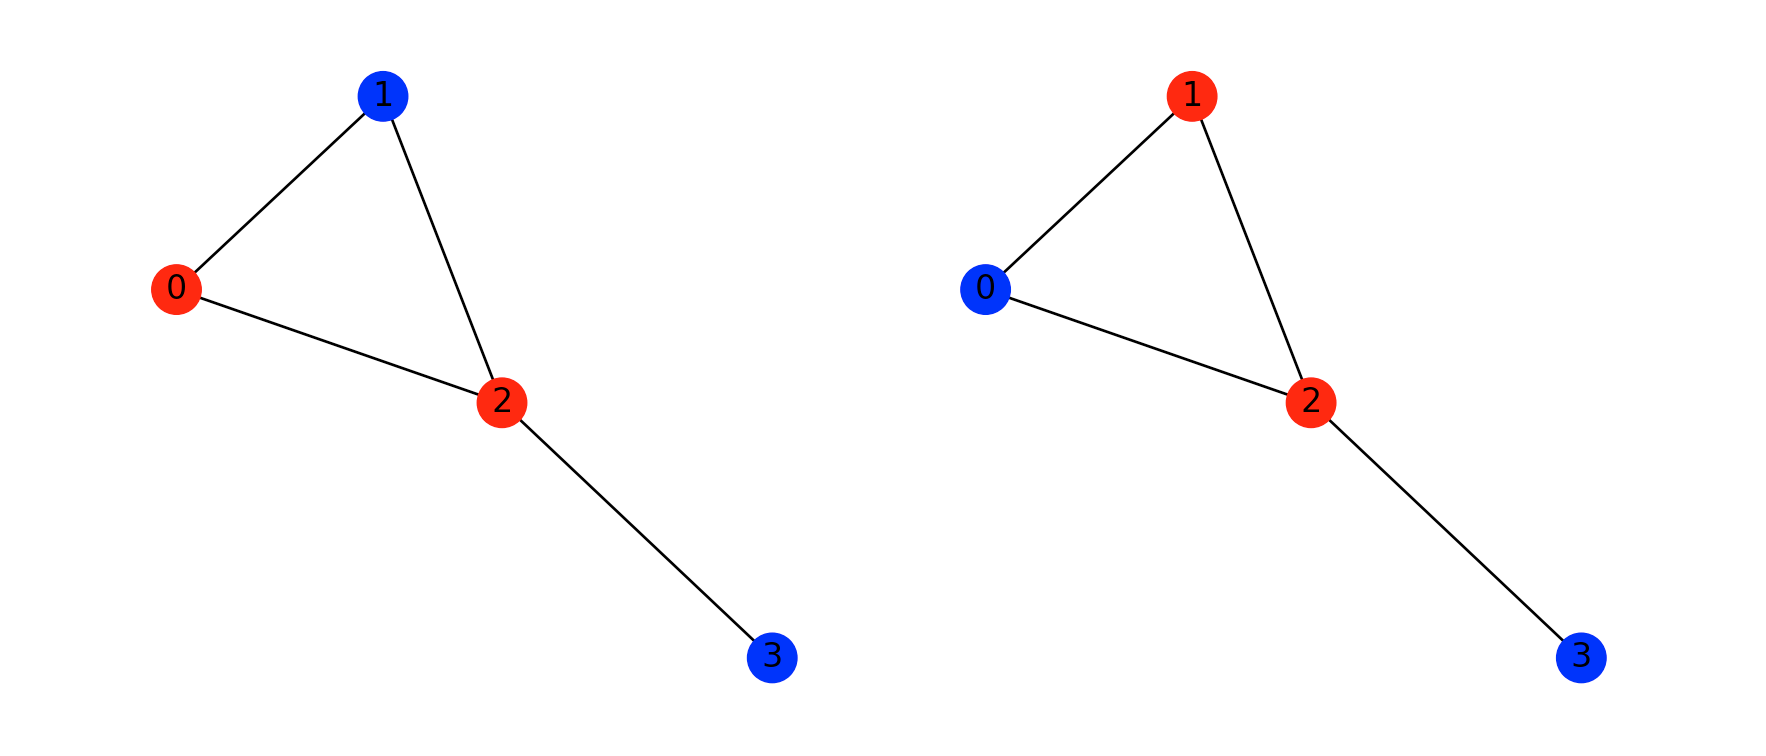

## Customizing QAOA  -- work in progress


In [65]:
reward_h = qaoa.edge_driver(nx.Graph([(0, 2)]), ['11'])

In [66]:
new_cost_h = cost_h + 2 * reward_h

In [59]:
'''
This calculation can take some time....
'''

'\nThis calculation can take some time....\n'

In [67]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, new_cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(new_cost_h)

params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.45959941 0.96095271]
 [0.27029962 0.78042396]]


Field for copy paste fast the result when you are working and wanna compare

Optimal Parameters
[[0.45959941 0.96095271]
 [0.27029962 0.78042396]]

[0.03609289 0.01610103 0.03954393 0.02500338 0.11724714 0.05667098
 0.14871304 0.02350147 0.01349722 0.07069289 0.26153384 0.02572074
 0.07113286 0.00243433 0.0889482  0.00316606]


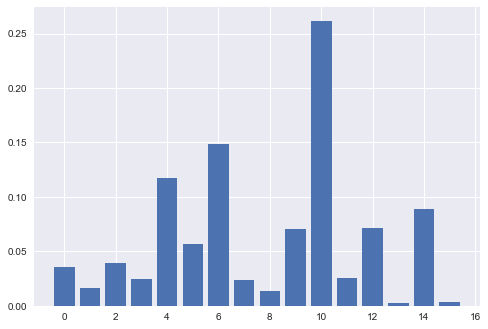

In [68]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

print(probs)
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

[0.03609289 0.01610103 0.03954393 0.02500338 0.11724714 0.05667098
 0.14871304 0.02350147 0.01349722 0.07069289 0.26153384 0.02572074
 0.07113286 0.00243433 0.0889482  0.00316606]

Just as we expected, the 
|10⟩ state is now favoured over |6⟩


Try making your own custom constraining terms. Is QAOA properly amplifying some bitstrings over others?